In [5]:
import tensorflow as tf
import pandas as pd
# import dask.dataframe as pd
# import dask.array as np
import numpy as np
import matplotlib.pyplot as plt
# import streamlit as st


def rmse(y1, y2):
    return np.sqrt(((y1-y2)**2).mean())


def plot_series(time, series, target, name='', format="-", start=0, end=None):
    # with st.container():
    # fig = plt.figure()
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel(target)
    plt.grid(True)
    plt.title(name)
    # st.pyplot(fig)


def window_dataset(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    return model.predict(ds)


def moving_avg_forcast(series, window_size):
    forcast = [
        series[time:time + window_size].mean()
        for time in range(len(series) - window_size)
    ]
    return np.array(forcast)


def naive_model(series, split_time, time_train, time_valid, x_train, x_valid, target):
    naive_forcast = series[split_time - 1:-1]
    print('naive_model that is our base model')
    # nav_fig = plt.figure()
    plt.figure()
    plot_series(time_valid, x_valid, target, 'naive model original valid')
    plot_series(time_valid, naive_forcast, target, 'naive model')
    # st.pyplot(nav_fig)
    base_mea = tf.keras.metrics.mean_absolute_error(
        x_valid, naive_forcast).numpy()
    print('base_mea', base_mea)

    print('base rmse:', rmse(x_valid, naive_forcast))

# @st.cache(ttl=7200)


def data(filename, target):
    print('i am in')
    time_stamp = []
    series = []
    print(type(filename))
    try:
        dat = pd.read_csv(filename)
        print(dat.head())
        # dat['datetime'] = pd.to_datetime(dat['datetime'])
        print(dat.info())
        dat = dat.dropna()
        print(dat.isna().sum())
        print(dat.info())
    except:
        print('enter except')
        print(type(filename))
        print('1')
        # dat = dat.join(dat.pop('data').apply(pd.Series))
        if isinstance(filename, pd.DataFrame):
            # if type(filename) == pd.core.frame.DataFrame:
            print('enter if')
            dat = filename
            print(dat.info())
            print(dat.tail(10))
        else:
            print('not loading data!!!!!')
    print('pikachu')
    series = np.array(list(pd.to_numeric(dat[target])))
    time_stamp = np.array(list(dat.index)).astype('float64')
    print('converted')
    # series = np.array(pd.to_numeric(dat[target]))
    # time_stamp = np.array(pd.to_numeric(list(dat.index)).astype('float64'))
    # with st.container():
    print('converted')
    # col1, col2 = st.columns(2)
    # with col1:
    print('series:', series)
    # with col2:
    print('time_stamp:', time_stamp)

    # basic_fig = plt.figure()
    plt.figure()
    print('plots')
    plot_series(time_stamp, series, target, 'plots')
    # st.pyplot(basic_fig)
    # zoomed_fig = plt.figure()
    plt.figure()
    print('zoomed view')
    plot_series(time_stamp[2500:2600],
                series[2500:2600], target, 'zoomed view')
    # st.pyplot(zoomed_fig)

    split_time = int(len(time_stamp)*80/100)
    time_train = time_stamp[:split_time]
    time_valid = time_stamp[split_time:]
    x_train = series[:split_time]
    x_valid = series[split_time:]
    # print(len(time_train))
    # print(len(time_valid))
    # print(len(x_train))
    # print(len(x_valid))
    print('plot with split look')
    # fig1 = plt.figure()
    plt.figure()
    plot_series(time_train, x_train, target, 'plot with split look')
    plot_series(time_valid, x_valid, target, 'plot with split look')
    # st.pyplot(fig1)
    # fig2 = plt.figure()
    plt.figure()
    print('time_valid vs x_valid')
    plot_series(time_valid, x_valid, target, 'time_valid vs x_valid')
    # st.pyplot(fig2)

    window_size = 25
    batch_size = 32
    shuffle_buffer_size = 1000

    naive_model(series, split_time, time_train,
                time_valid, x_train, x_valid, target)

    def moving_avg():
        moving_avg = moving_avg_forcast(series, 25)[split_time-25:]
        # len(moving_avg)
        print('moving average model that is our check model')
        # fig3 = plt.figure()
        plt.figure()
        plot_series(time_valid, x_valid, target,
                    'moving average model x_valid')
        plot_series(time_valid, moving_avg, target, 'moving average model')
        # st.pyplot(fig3)
        mea_mov_avg = tf.keras.metrics.mean_absolute_error(
            x_valid, moving_avg).numpy()
        print('mea:', mea_mov_avg)
        print('base rmse:', rmse(x_valid, moving_avg))

        diff_series = series[720:]-series[:-720]
        diff_time = time_stamp[720:]
        print('diff_series')
        # fig4 = plt.figure()
        plt.figure()
        plot_series(diff_time, diff_series, target, 'diff_series plot')
        # st.pyplot(fig4)

        diff_moving_avg = moving_avg_forcast(diff_series, 25)[
            split_time-720-25:]
        len(diff_moving_avg)
        print('diff_moving_avg')
        # fig5 = plt.figure()
        plt.figure()
        plot_series(time_valid, x_valid, target, 'diff_moving_avg x_valid')
        plot_series(time_valid, diff_moving_avg,
                    target, 'diff_moving_avg plot')
        # st.pyplot(fig5)
        mea_mov_avg_diff = tf.keras.metrics.mean_absolute_error(
            x_valid, diff_moving_avg).numpy()
        print('mea:', mea_mov_avg_diff)
        print('base rmse:', rmse(x_valid, diff_moving_avg))

        diff_mov_avg_inc_past = series[split_time-720:-720]+diff_moving_avg
        print('diff_mov_avg_inc_past')
        # fig6 = plt.figure()
        plt.figure()
        plot_series(time_valid, x_valid, target,
                    'diff_mov_avg_inc_past x_valid')
        plot_series(time_valid, diff_mov_avg_inc_past,
                    target, 'diff_mov_avg_inc_past')
        # st.pyplot(fig6)
        mea_mov_avg_diff_past = tf.keras.metrics.mean_absolute_error(
            x_valid, diff_mov_avg_inc_past).numpy()
        print('mea:', mea_mov_avg_diff_past)
        print('base rmse:', rmse(x_valid, diff_mov_avg_inc_past))

        diff_mov_avg_smooth_past = moving_avg_forcast(
            series[split_time-745:-720], 25)
        diff_mov_avg_smooth_past = diff_mov_avg_smooth_past + diff_moving_avg
        print('diff_mov_avg_smooth_past')
        # fig7 = plt.figure()
        plt.figure()
        plot_series(time_valid, x_valid, target,
                    'diff_mov_avg_smooth_past x_valid')
        plot_series(time_valid, diff_mov_avg_smooth_past,
                    target, 'diff_mov_avg_smooth_past')
        # st.pyplot(fig7)
        final_mov_avg_mea = tf.keras.metrics.mean_absolute_error(
            x_valid, diff_mov_avg_smooth_past).numpy()
        print('mea:', final_mov_avg_mea)
        print('base rmse:', rmse(x_valid, diff_mov_avg_smooth_past))

    # @st.cache(ttl=7200)

    def try_train():
        print('train dnn trying....')
        # down_code
        tf.keras.backend.clear_session()
        tf.random.set_seed(51)
        np.random.seed(51)
        window_size = 64
        batch_size = 256
        train_set = window_dataset(
            x_train, window_size, batch_size, shuffle_buffer_size)
        print(train_set)
        print(x_train.shape)

        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.LSTM(32, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 400)
        ])
        # tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),

        lr_schedule = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch / 20))
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])
        history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

        plt.semilogx(history.history["lr"], history.history["loss"])
        plt.axis([1e-8, 1e-4, 0, 300])

        """-------------"""
        loss = history.history['loss']
        epochs = range(len(loss))  # Get number of epochs
        # ------------------------------------------------
        # Plot training and validation loss per epoch
        # ------------------------------------------------
        # fig8 = plt.figure()
        plt.figure()
        plt.plot(epochs, loss, 'r')
        plt.title('Training loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Loss"])
        # st.pyplot(fig8)

    """-------------"""
    print('train dnn final')
    # @st.cache(ttl=7200)

    def train():
        rmse = tf.keras.metrics.RootMeanSquaredError()
        tf.keras.backend.clear_session()
        tf.random.set_seed(51)
        np.random.seed(51)
        train_set = window_dataset(
            x_train, window_size=45, batch_size=100, shuffle_buffer_size=shuffle_buffer_size)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                                   strides=1, padding="causal",
                                   activation="relu",
                                   input_shape=[None, 1]),
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 400)
        ])
        #
#            tf.keras.layers.Conv1D(filters=60, kernel_size=5,
#                                   strides=1, padding="causal",
#                                   activation="relu",
#                                   input_shape=[None, 1]),

        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=[rmse, "mae"])
        history = model.fit(train_set, epochs=10000)
        # history = model.fit(train_set, epochs=500)
        return history, model

    """-------------"""
    def train_loss(history):
        print('train losses')
        loss = history.history['loss']
        epochs = range(len(loss))  # Get number of epochs

        # ------------------------------------------------
        # Plot training and validation loss per epoch
        # ------------------------------------------------
        # fig9 = plt.figure()
        plt.figure()
        plt.plot(epochs, loss, 'r')
        plt.title('Training loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Loss"])
        # st.pyplot(fig9)

        try:
            zoomed_loss = loss[9000:10000]
            zoomed_epochs = range(9000, 10000)

            # ------------------------------------------------
            # Plot training and validation loss per epoch
            # ------------------------------------------------
            # fig10 = plt.figure()
            plt.figure()
            plt.plot(zoomed_epochs, zoomed_loss, 'r')
            plt.title('Training loss')
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend(["Loss"])
            # st.pyplot(fig10)
        except:
            print(" .. ")

    """-------------"""
    moving_avg()
    # try_train()
    history, model = train()
    train_loss(history)

    """-------------"""

    forecast = model_forecast(
        model, series[..., np.newaxis], window_size, batch_size)
    forecast = forecast[split_time - window_size:-1, -1, 0]
    print('forcast-----------> \n', forecast)

    print('plot for forecast')
    # fig11 = plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10, 6))
    plot_series(time_valid, x_valid, target, 'plot for forecast x_valid')
    plot_series(time_valid, forecast, target, 'plot for forecast lstm')
    # st.pyplot(fig11)

    mea = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
    print('mae:', mea)

    def mae_py(y_true, predictions):
        y_true, predictions = np.array(y_true), np.array(predictions)
        return np.mean(np.abs(y_true - predictions))
    mean_abs_err = mae_py(x_valid, forecast)
    print(mean_abs_err)

    # rmse = tf.keras.metrics.root_mean_squared_error(x_valid, forecast).numpy()
    rms = np.sqrt(rmse(x_valid, forecast))
    print('rmse:', rms)

    mse = tf.keras.metrics.mean_squared_error(x_valid, forecast).numpy()
    print('mse:', mse)

    def mse_py(true, pred):
        return np.square(np.subtract(true, pred)).mean()
    print('mse_py:', mse_py(x_valid, forecast))
    root_mse = np.sqrt(mse)
    print('root_mse:', root_mse)


"""-------------"""
# data('all_data_bike2.csv','count')
# data('out_clean.csv', 'Total Generation (KWH)')


'-------------'

Streaming output truncated to the last 5000 lines.
19/19 [==============================] - 1s 25ms/step - loss: 223.8369 - root_mean_squared_error: 452.8725 - mae: 224.3353
Epoch 7546/10000
19/19 [==============================] - 1s 24ms/step - loss: 238.0256 - root_mean_squared_error: 463.5545 - mae: 238.5242
Epoch 7547/10000
19/19 [==============================] - 1s 24ms/step - loss: 239.0372 - root_mean_squared_error: 462.6060 - mae: 239.5359
Epoch 7548/10000
19/19 [==============================] - 1s 24ms/step - loss: 233.6201 - root_mean_squared_error: 456.3932 - mae: 234.1187
Epoch 7549/10000
19/19 [==============================] - 1s 25ms/step - loss: 242.1961 - root_mean_squared_error: 462.9992 - mae: 242.6948
Epoch 7550/10000
19/19 [==============================] - 1s 25ms/step - loss: 245.4046 - root_mean_squared_error: 467.2462 - mae: 245.9035
Epoch 7551/10000
19/19 [==============================] - 1s 24ms/step - loss: 241.8158 - root_mean_squared_error: 466.0345 - 

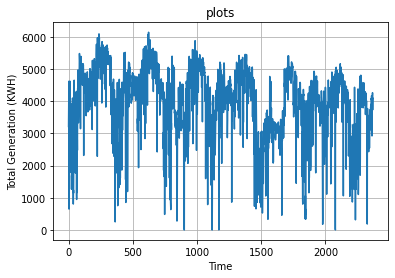

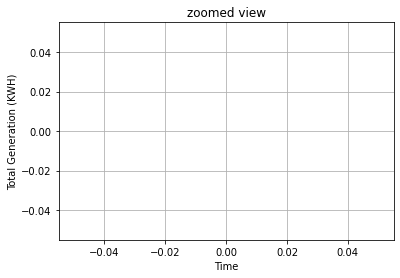

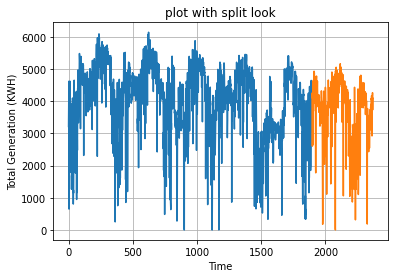

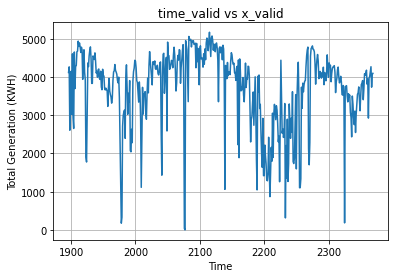

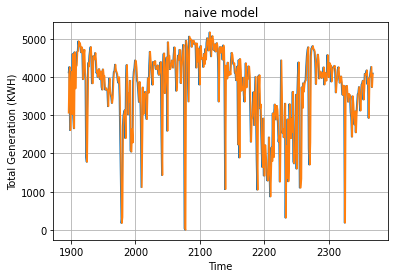

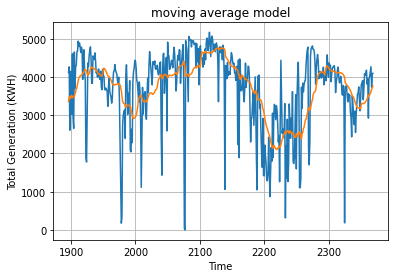

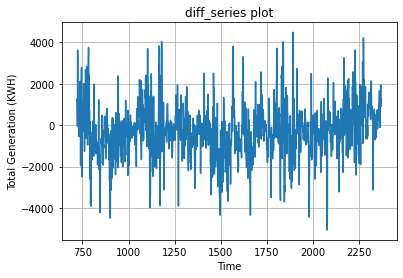

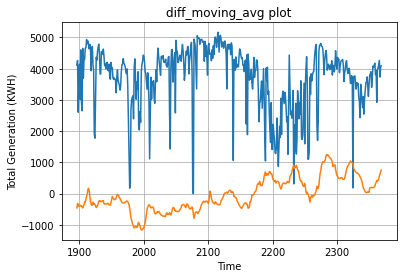

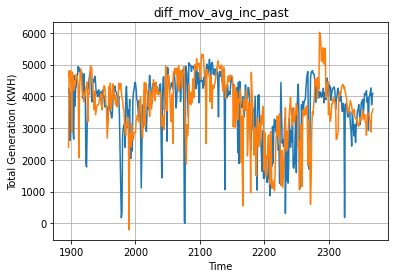

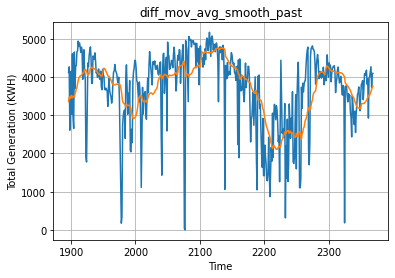

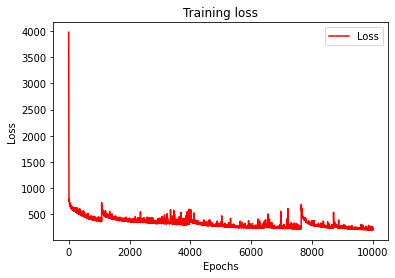

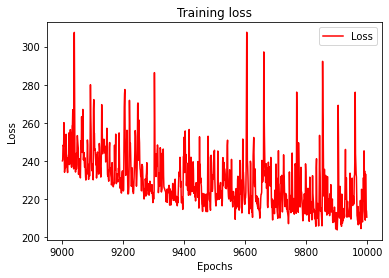

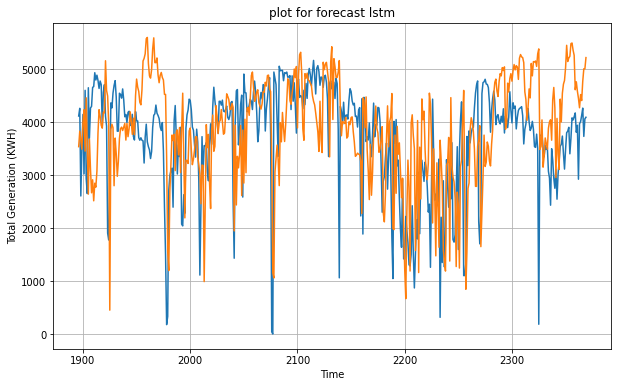

In [6]:
data('out_clean.csv', 'Total Generation (KWH)')